In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from tqdm import tqdm

In [ ]:
# Define device (Ensure consistency)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/dataset.zip" -d "/content/micro-dataset"

Archive:  /content/drive/MyDrive/dataset.zip
   creating: /content/micro-dataset/dataset/
   creating: /content/micro-dataset/dataset/negative/
  inflating: /content/micro-dataset/dataset/negative/1.png  
  inflating: /content/micro-dataset/dataset/negative/10.png  
  inflating: /content/micro-dataset/dataset/negative/100.png  
  inflating: /content/micro-dataset/dataset/negative/1000.png  
  inflating: /content/micro-dataset/dataset/negative/1001.png  
  inflating: /content/micro-dataset/dataset/negative/1002.png  
  inflating: /content/micro-dataset/dataset/negative/1003.png  
  inflating: /content/micro-dataset/dataset/negative/1004.png  
  inflating: /content/micro-dataset/dataset/negative/1005.png  
  inflating: /content/micro-dataset/dataset/negative/1006.png  
  inflating: /content/micro-dataset/dataset/negative/1007.png  
  inflating: /content/micro-dataset/dataset/negative/1008.png  
  inflating: /content/micro-dataset/dataset/negative/1009.png  
  inflating: /content/micro-da

In [ ]:
# Define dataset path
data_dir = "/content/micro-dataset/dataset/"
data_dir

'/content/micro-dataset/dataset/'

In [ ]:
from torchvision import transforms

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit VGG16
    transforms.ToTensor(),  # Convert image to tensor
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

class SafeImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        try:
            return super(SafeImageFolder, self).__getitem__(index)
        except (IOError, OSError):
            print(f"❌ Skipping corrupt image at index {index}")
            return None

# Use the custom dataset loader
full_dataset = SafeImageFolder(root=data_dir, transform=transform)


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
import torch.optim as optim

# Load dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split into train (70%) and temp (30%) first
train_indices, temp_indices = train_test_split(range(len(full_dataset)), test_size=0.3, random_state=42)

# Further split temp into val (15%) and test (15%)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

# Create subsets
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")

Train size: 1890, Val size: 405, Test size: 405


In [ ]:
# Print class labels and names
class_names = full_dataset.classes
class_to_idx = full_dataset.class_to_idx
print("Class Labels and Corresponding Class Names:")
for label, name in class_to_idx.items():
    print(f"Label {name}: {label}")

# Verify dataset sizes
print(f"Total images: {len(full_dataset)}, Train: {len(train_dataset)}, Validation: {len(val_dataset)}")

Class Labels and Corresponding Class Names:
Label 0: negative
Label 1: positive
Total images: 2700, Train: 1890, Validation: 405


In [ ]:
# Load the pre-trained VGG16 model (without default weights)
model = models.vgg16(pretrained=False)
# Modify the classifier to match 7 output classes (same as saved model)
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 7)  # Ensure compatibility

# Load trained weights
model.load_state_dict(torch.load("/content/drive/MyDrive/best_model.pth"))

# Modify the classifier for 2 classes (for micro-expression dataset)
model.classifier[6] = nn.Linear(num_features, 2)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
import torch.optim.lr_scheduler as lr_scheduler

# Optionally, freeze feature extractor layers
for param in model.features.parameters():
    param.requires_grad = False

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # ✅ No more errors!


In [ ]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Early Stopping
from torch.optim import lr_scheduler

# Early stopping utility
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0  # Reset counter
        else:
            self.counter += 1  # Increase counter if no improvement
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered! 🚀")


early_stopping = EarlyStopping(patience=5, verbose=True)  # Stop if val loss doesn't improve in 5 epochs


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # ✅ Allow PIL to load truncated images


In [ ]:
def train_model(model, train_dataset, val_dataset, criterion, optimizer, scheduler, num_epochs=10, patience=5, save_path = "fine_tuned_micro_expression.pth" ):
    best_val_loss = float("inf")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        print(f"\nEpoch [{epoch+1}/{num_epochs}]")

        # Training phase
        train_progress = tqdm(train_loader, desc="Training", leave=False)
        for images, labels in train_progress:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Update tqdm description
            train_progress.set_postfix(loss=loss.item())

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        val_progress = tqdm(val_loader, desc="Validating", leave=False)
        with torch.no_grad():
            for images, labels in val_progress:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                # Update tqdm description
                val_progress.set_postfix(loss=loss.item())

        val_loss /= len(val_loader)
        val_acc = 100. * correct / total

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_micro_expression_model.pth")
            print("✅ Model saved!")

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer,scheduler, num_epochs=50, patience=5, save_path="best_model.pth")


Epoch [1/50]


Train Loss: 0.4386, Train Acc: 79.52% | Val Loss: 0.2583, Val Acc: 86.91%
✅ Model saved!

Epoch [2/50]


Train Loss: 0.2500, Train Acc: 89.37% | Val Loss: 0.1653, Val Acc: 92.59%
✅ Model saved!

Epoch [3/50]


Train Loss: 0.1806, Train Acc: 92.38% | Val Loss: 0.2454, Val Acc: 88.40%

Epoch [4/50]


Train Loss: 0.1536, Train Acc: 94.13% | Val Loss: 0.0994, Val Acc: 94.32%
✅ Model saved!

Epoch [5/50]


Train Loss: 0.1104, Train Acc: 95.66% | Val Loss: 0.1926, Val Acc: 94.07%

Epoch [6/50]


Train Loss: 0.1428, Train Acc: 95.13% | Val Loss: 0.1317, Val Acc: 94.32%

Epoch [7/50]


Train Loss: 0.1148, Train Acc: 96.03% | Val Loss: 0.1376, Val Acc: 95.06%

Epoch [8/50]


Train Loss: 0.0814, Train Acc: 96.88% | Val Loss: 0.2343, Val Acc: 93.58%

Epoch [9/50]


Train Loss: 0.0948, Train Acc: 96.93% | Val Loss: 0.1435, Val Acc: 94.81%

Epoch [10/50]


Train Loss: 0.0602, Train Acc: 97.57% | Val Loss: 0.0879, Val Acc: 97.04%
✅ Model saved!

Epoch [11/50]


Train Loss: 0.0992, Train Acc: 97.09% | Val Loss: 0.1524, Val Acc: 95.31%

Epoch [12/50]


Train Loss: 0.0568, Train Acc: 98.47% | Val Loss: 0.1415, Val Acc: 96.30%

Epoch [13/50]


Train Loss: 0.0805, Train Acc: 97.25% | Val Loss: 0.1413, Val Acc: 96.05%

Epoch [14/50]


Train Loss: 0.1152, Train Acc: 97.04% | Val Loss: 0.1050, Val Acc: 96.05%

Epoch [15/50]


Train Loss: 0.0526, Train Acc: 98.36% | Val Loss: 0.1618, Val Acc: 95.80%

Epoch [16/50]


Train Loss: 0.0502, Train Acc: 98.62% | Val Loss: 0.1080, Val Acc: 95.80%

Epoch [17/50]


Train Loss: 0.0482, Train Acc: 98.62% | Val Loss: 0.0654, Val Acc: 97.53%
✅ Model saved!

Epoch [18/50]


Train Loss: 0.0524, Train Acc: 98.36% | Val Loss: 0.1044, Val Acc: 96.30%

Epoch [19/50]


Train Loss: 0.0460, Train Acc: 98.47% | Val Loss: 0.2122, Val Acc: 96.05%

Epoch [20/50]


Train Loss: 0.0423, Train Acc: 98.84% | Val Loss: 0.0818, Val Acc: 97.28%

Epoch [21/50]


Train Loss: 0.0420, Train Acc: 98.52% | Val Loss: 0.1710, Val Acc: 95.80%

Epoch [22/50]


Train Loss: 0.0477, Train Acc: 98.99% | Val Loss: 0.1510, Val Acc: 95.31%

Epoch [23/50]


Train Loss: 0.0795, Train Acc: 98.04% | Val Loss: 0.2113, Val Acc: 93.58%

Epoch [24/50]


Train Loss: 0.0460, Train Acc: 98.57% | Val Loss: 0.1181, Val Acc: 97.04%

Epoch [25/50]


Train Loss: 0.0445, Train Acc: 98.94% | Val Loss: 0.0709, Val Acc: 98.27%

Epoch [26/50]


Train Loss: 0.0616, Train Acc: 99.21% | Val Loss: 0.0836, Val Acc: 97.28%

Epoch [27/50]


Train Loss: 0.0549, Train Acc: 98.62% | Val Loss: 0.0649, Val Acc: 97.78%
✅ Model saved!

Epoch [28/50]


Train Loss: 0.0626, Train Acc: 98.31% | Val Loss: 0.1358, Val Acc: 96.54%

Epoch [29/50]


Train Loss: 0.0301, Train Acc: 99.31% | Val Loss: 0.0997, Val Acc: 97.28%

Epoch [30/50]


Train Loss: 0.0199, Train Acc: 99.26% | Val Loss: 0.2321, Val Acc: 94.32%

Epoch [31/50]


Train Loss: 0.0625, Train Acc: 98.47% | Val Loss: 0.1158, Val Acc: 98.27%

Epoch [32/50]


Train Loss: 0.0475, Train Acc: 98.99% | Val Loss: 0.1428, Val Acc: 97.28%

Epoch [33/50]


Train Loss: 0.0397, Train Acc: 98.99% | Val Loss: 0.1280, Val Acc: 97.28%

Epoch [34/50]


Train Loss: 0.0142, Train Acc: 99.68% | Val Loss: 0.1209, Val Acc: 97.04%

Epoch [35/50]


Train Loss: 0.0136, Train Acc: 99.42% | Val Loss: 0.1236, Val Acc: 97.04%

Epoch [36/50]


Train Loss: 0.0205, Train Acc: 99.42% | Val Loss: 0.3036, Val Acc: 96.05%

Epoch [37/50]


Train Loss: 0.0375, Train Acc: 98.99% | Val Loss: 0.1387, Val Acc: 95.80%

Epoch [38/50]


Train Loss: 0.0614, Train Acc: 98.84% | Val Loss: 0.1281, Val Acc: 97.04%

Epoch [39/50]


Train Loss: 0.0720, Train Acc: 98.41% | Val Loss: 0.1725, Val Acc: 96.54%

Epoch [40/50]


Train Loss: 0.0626, Train Acc: 98.78% | Val Loss: 0.0949, Val Acc: 96.54%

Epoch [41/50]


Train Loss: 0.0259, Train Acc: 99.10% | Val Loss: 0.1771, Val Acc: 97.28%

Epoch [42/50]


Train Loss: 0.0283, Train Acc: 99.26% | Val Loss: 0.4903, Val Acc: 94.32%

Epoch [43/50]


Train Loss: 0.0174, Train Acc: 99.58% | Val Loss: 0.3790, Val Acc: 95.06%

Epoch [44/50]


Train Loss: 0.0192, Train Acc: 99.63% | Val Loss: 0.1182, Val Acc: 97.28%

Epoch [45/50]


Train Loss: 0.0140, Train Acc: 99.63% | Val Loss: 0.1809, Val Acc: 97.53%

Epoch [46/50]


Train Loss: 0.0404, Train Acc: 99.21% | Val Loss: 0.1240, Val Acc: 97.04%

Epoch [47/50]


Train Loss: 0.0356, Train Acc: 99.10% | Val Loss: 0.1386, Val Acc: 96.79%

Epoch [48/50]


Train Loss: 0.0384, Train Acc: 98.99% | Val Loss: 0.1290, Val Acc: 97.04%

Epoch [49/50]


Train Loss: 0.0364, Train Acc: 99.63% | Val Loss: 0.2919, Val Acc: 95.56%

Epoch [50/50]


Train Loss: 0.0527, Train Acc: 99.05% | Val Loss: 0.1577, Val Acc: 96.79%


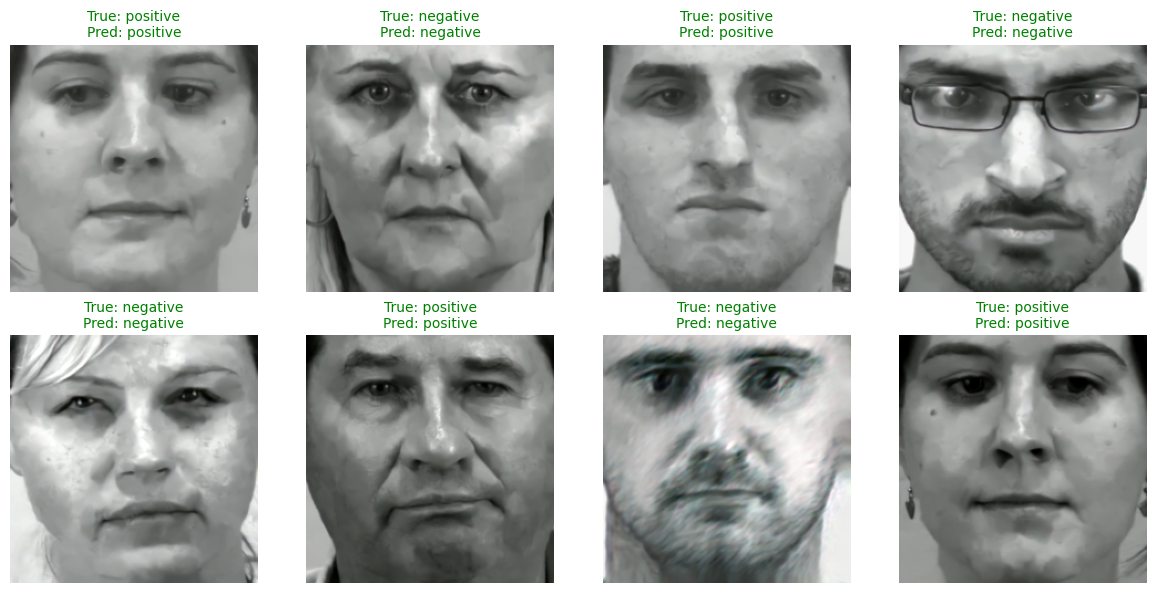

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms

# Load the saved model weights
model.load_state_dict(torch.load("best_micro_expression_model.pth"))
model.eval()

# Define class names
class_names = full_dataset.classes  # ['negative', 'positive']

# Mean and std used in normalization (Check your transform values)
mean = [0.485, 0.456, 0.406]  # Adjust if different
std = [0.229, 0.224, 0.225]

# Function to undo normalization
def denormalize(img_tensor):
    img_tensor = img_tensor.clone().cpu().numpy()  # Convert to NumPy
    img_tensor = img_tensor * np.array(std).reshape(3, 1, 1) + np.array(mean).reshape(3, 1, 1)  # Reverse normalize
    img_tensor = np.clip(img_tensor, 0, 1)  # Clip values between 0 and 1
    return np.transpose(img_tensor, (1, 2, 0))  # Convert to (H, W, C)

# Get 8 images from test_loader
images, labels = next(iter(test_loader))
images, labels = images[:8], labels[:8]

# Move images to device
images = images.to(device)

# Get predictions
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Plot images with predictions
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    img = denormalize(images[i])  # Undo normalization
    true_label = class_names[labels[i].item()]
    pred_label = class_names[predicted[i].item()]

    ax.imshow(img)
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10, color="green" if true_label == pred_label else "red")
    ax.axis("off")

plt.tight_layout()
plt.show()


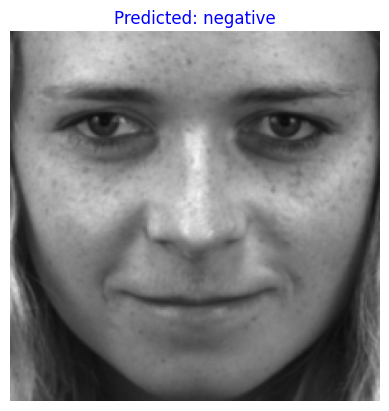

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load the saved model
model.load_state_dict(torch.load("best_micro_expression_model.pth"))
model.eval()

# Define class names
class_names = full_dataset.classes  # ['negative', 'positive']

# Define the same transform as used during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match VGG16 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Use same normalization
])

# Load the image (change "example.jpg" to your image path)
image_path = "/content/hp.png"
image = Image.open(image_path).convert("RGB")  # Ensure RGB format
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Move to device (CPU/GPU)
input_tensor = input_tensor.to(device)

# Get prediction
with torch.no_grad():
    output = model(input_tensor)
    _, predicted_class = torch.max(output, 1)

# Get class label
predicted_label = class_names[predicted_class.item()]

# Undo normalization for display
def denormalize(img_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_tensor = img_tensor.cpu().numpy().transpose(1, 2, 0)  # Convert to HWC
    img_tensor = img_tensor * std + mean  # Reverse normalization
    img_tensor = np.clip(img_tensor, 0, 1)  # Clip values between 0 and 1
    return img_tensor

# Plot the image with the predicted label
plt.imshow(denormalize(input_tensor.squeeze(0)))
plt.title(f"Predicted: {predicted_label}", fontsize=12, color="blue")
plt.axis("off")
plt.show()
